In [1]:
# Dimitrios Bakalis

import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
yes_list = []
for filename in glob.glob(r'data_set\yes\*.jpg'): 
    image = Image.open(filename).convert('RGB')    # loading an RGB image (.jpg)
    resized_image = image.resize((400, 400))       # resizing the image to 400 x 400
    yes_list.append(resized_image)                 # saving the image to a list 

no_list = []
for filename in glob.glob(r'data_set\no\*.jpg'): 
    image = Image.open(filename).convert('RGB')
    resized_image = image.resize((400, 400))
    no_list.append(resized_image)

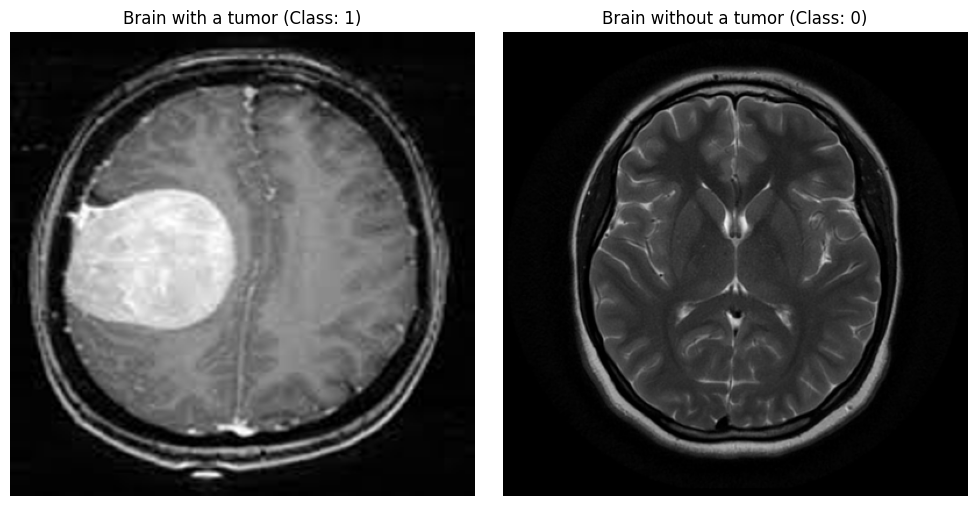

In [3]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the first image (tumor)
axes[0].imshow(yes_list[0], cmap='gray')
axes[0].set_title("Brain with a tumor (Class: 1)")
axes[0].axis('off')  # Hide axes

# Show the second image (no tumor)
axes[1].imshow(no_list[0], cmap='gray')
axes[1].set_title("Brain without a tumor (Class: 0)")
axes[1].axis('off')

# Display the images
plt.tight_layout()
plt.show()

In [4]:
# Convert images to numpy arrays and create labels
np_yes_list = [np.array(image) for image in yes_list]
np_no_list = [np.array(image) for image in no_list]

# Combine data and labels
data = np.array(np_no_list + np_yes_list)
labels = np.array([0] * len(no_list) + [1] * len(yes_list))

print("data shape:", data.shape)
print("labels shape:", labels.shape)

data shape: (249, 400, 400, 3)
labels shape: (249,)


In [5]:
from sklearn.model_selection import train_test_split

# First split: Separate out test set with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    data, labels, 
    test_size=20,
    stratify=labels,
    random_state=109
)

# Second split: Separate validation from training with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=30,  
    stratify=y_temp,
    random_state=109
)

print("Train data:", X_train.shape, "- Label distribution:", np.bincount(y_train))
print("Validation data:", X_val.shape, "- Label distribution:", np.bincount(y_val))
print("Test data:", X_test.shape, "- Label distribution:", np.bincount(y_test))

Train data: (199, 400, 400, 3) - Label distribution: [ 75 124]
Validation data: (30, 400, 400, 3) - Label distribution: [11 19]
Test data: (20, 400, 400, 3) - Label distribution: [ 8 12]


In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(400, 400, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

In [7]:
model.compile(  loss = 'binary_crossentropy', 
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                metrics = ['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (you can also use 'val_accuracy', etc.)
    patience=10,                 # Number of epochs to wait after last improvement
    restore_best_weights=True   # Restores the best weights after stopping
)

# Train the model with early stopping
model_fit = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=25,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.5578 - loss: 0.7901 - val_accuracy: 0.3667 - val_loss: 0.6932
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.5879 - loss: 0.6915 - val_accuracy: 0.7333 - val_loss: 0.6570
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.6281 - loss: 0.8859 - val_accuracy: 0.3667 - val_loss: 1.9184
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.6533 - loss: 2.3694 - val_accuracy: 0.7667 - val_loss: 1.1458
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.6583 - loss: 0.8194 - val_accuracy: 0.6333 - val_loss: 0.6224
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - accuracy: 0.7337 - loss: 0.6199 - val_accuracy: 0.6667 - val_loss: 0.6671
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.6834 - loss: 0.6789 - val_accuracy: 0.6333 - val_loss: 0.6025
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 0.5980 - loss: 2.4510 - val_accuracy: 0.6333 - val_loss:

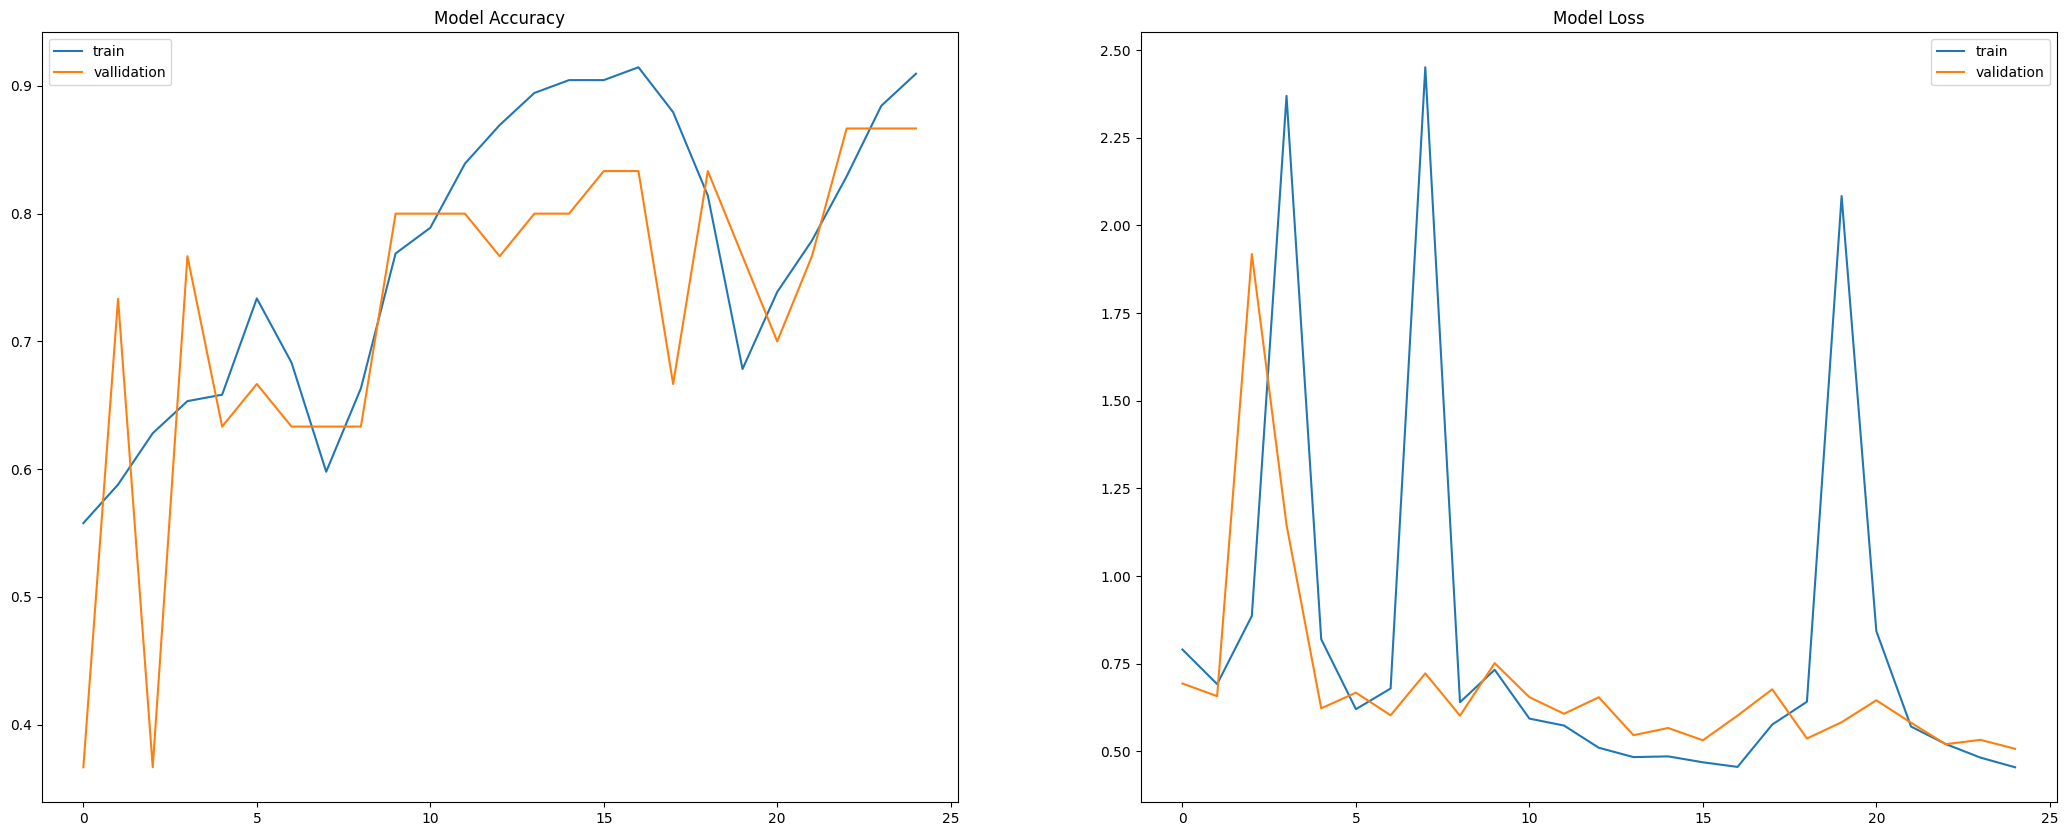

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(26, 10)

ax1.set_title('Model Accuracy')
ax1.plot(model_fit.history['accuracy'], label='train')
ax1.plot(model_fit.history['val_accuracy'], label='vallidation')
ax1.legend()

ax2.set_title('Model Loss')
ax2.plot(model_fit.history['loss'], label='train')
ax2.plot(model_fit.history['val_loss'], label='validation')
ax2.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[[ 5  3]
 [ 0 12]]
Test Accuracy 0.85


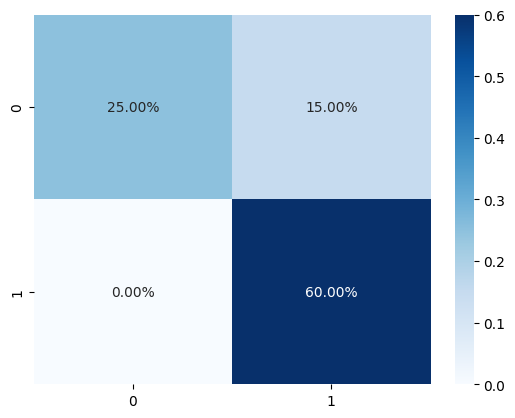

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

pred = (model.predict(X_test) > 0.5).astype("int32")

mat = confusion_matrix(y_test,pred)
print(mat)

sns.heatmap(mat/np.sum(mat), annot=True, 
            fmt='.2%', cmap='Blues')

acc = accuracy_score(y_test, pred)
print("Test Accuracy", acc)

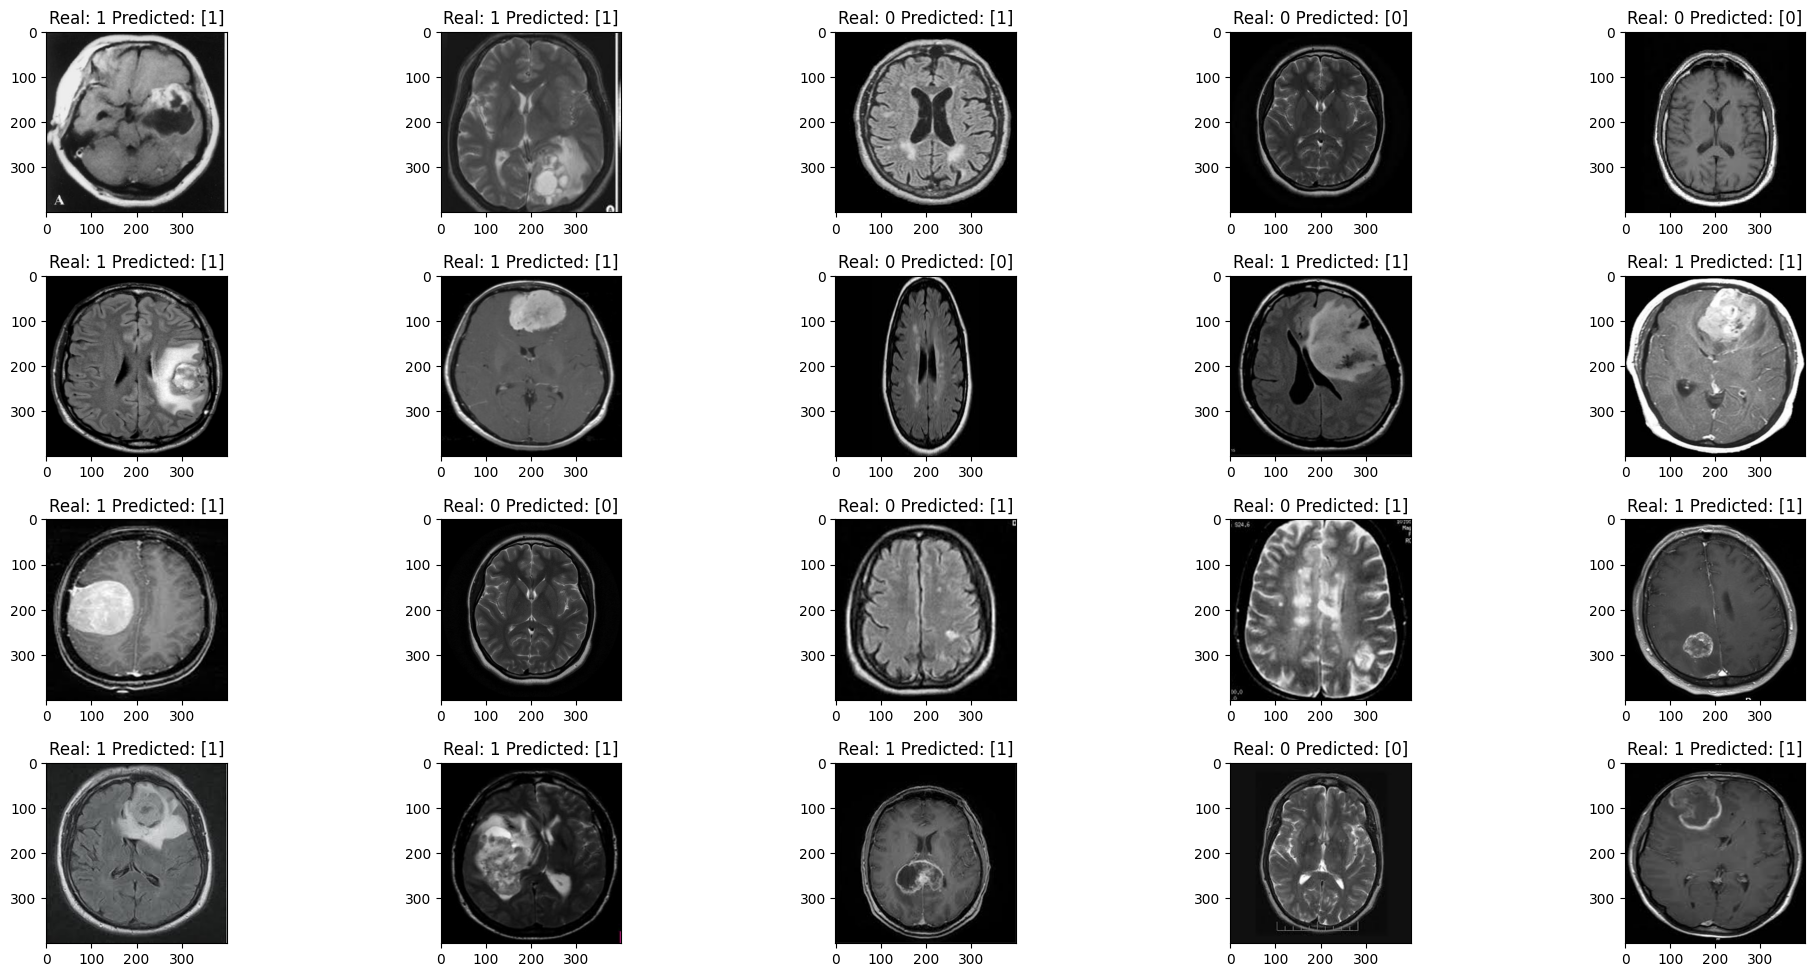

In [15]:
fig = plt.figure(figsize=(25,15))
fig.subplots_adjust(hspace=0.35, wspace=0.1)

i=-1
for image in X_test:
    i+=1
    ax = fig.add_subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    title = "Real: " + str(y_test[i]) + " Predicted: " + str(pred[i])
    plt.title(title)

plt.show()